In [3]:
import pandas as pd
import numpy as np

In [17]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

from scipy.io import wavfile
from scipy.stats.mstats import normaltest, skewtest, kurtosistest

## Import FastICA Algorithm

In [5]:
from parallel_ica import perform_fastica, inverse_fastica

## Functions from Demo

In [102]:
# Normalize audio amplitude between -0.5 and 0.5
def audionorm(data):
    # ensure data is ndarray with float numbers
    data = np.asarray(data).astype('float')
    # calculate lower and upper bound
    lbound, ubound = np.min(data), np.max(data)
    if lbound == ubound:
        offset = lbound
        scalar = 1
        data = np.zeros(size=data.shape)
    else:
        offset = (lbound + ubound) / 2
        scalar = 1 / (ubound - lbound)
        data = (data - offset) * scalar
    # return normalized data
    return data

# Mix a matrix of samples using a random mixing matrix
def simpleMixer(S):
    nchannel = S.shape[0]
    # generate a random matrix
    A = np.random.uniform(size = (nchannel,nchannel))
    # generate mixed audio data
    X = A.dot(S)
    
    return X, A

# Plot the mixed signal with the mixing matrix
def drawDataWithMixingMatrix(data, mat, ground_truth=True):
    plt.figure(figsize=(8, 6))
    # plot data points
    plt.scatter(data[0], data[1], s=2, alpha = 0.6)
    # calculate axis length
    lenAxis = np.sqrt(np.sum(np.square(mat), axis=0))
    # calculate scale for illustration
    scale = np.min(np.max(np.abs(data), axis=1) / lenAxis.T)
    # draw axis as arrow
    plt.arrow(0, 0, scale * mat[0,0], scale * mat[1,0], shape='full', color='r')
    plt.arrow(0, 0, scale * mat[0,1], scale * mat[1,1], shape='full', color='r')
    if ground_truth:
        plt.title('Data with True Mixing Matrix', size = 18)
    else:
        plt.title('Data with Estimated Mixing Matrix', size = 18)
    
# Show mixed signal with true mixing matrix and estimated mixing matrix
def compareMixingMatrix(data, matA, matB):
    # plot first mixing matrix
    drawDataWithMixingMatrix(data, matA)
    # plot first mixing matrix
    drawDataWithMixingMatrix(data, matB, ground_truth=False)

In [47]:
srate, bach_sample = wavfile.read('../data/bach.wav')
_, speech_sample = wavfile.read('../data/speech.wav')

## Check Gaussianity of Data

In [48]:
def check_gaussianity(X):
    # Perform D'Agostino and Pearson's test to determine normality
    # Combines skew and kurtosis for combined test of normality
    # k2 = s^2 + k^2 where s is skew and k is kurtosis
    test_result = normaltest(X)
    print('Normal Test p-value = {:0.4f}'.format(test_result.pvalue))
    
    # Calculate actual skew and kurtosis
    skew = skewtest(X).statistic
    kurtosis = kurtosistest(X).statistic
    
    # Find Gaussian and Laplacian Distributions of same length
    gaussian = np.random.randn(len(X))
    laplacian = np.random.laplace(size = len(X))
    
    # Interpret p-value
    if test_result.pvalue < 0.05:
        print('Reject Null Hypothesis that sample comes'
              ' from a normal distribution at alpha = 0.05')
    else:
        print('Fail to reject Null Hypothesis that sample'
              ' comes from a normal distribution at alpha= 0.05')
        
        
    print('\nSample Distribution Skew = {:0.4f}'
              '  Kurtosis = {:0.4f}'.format(skew, kurtosis))
    
    print('Gaussian Distribution Skew = {:0.4f}'
              '  Kurtosis = {:0.4f}'.format(skewtest(gaussian).statistic, 
                                            kurtosistest(gaussian).statistic))
    print('Laplacian Distribution Skew = {:0.4f}'
              '  Kurtosis = {:0.4f}\n'.format(skewtest(laplacian).statistic, 
                                            kurtosistest(laplacian).statistic))
    
    
    plt.figure(figsize=(16, 8))
    
    # Plot sample distribution
    plt.subplot(131)
    sns.distplot(X, kde=True, hist=True, bins=30, color = 'blue')
    plt.xlabel('Amplitude', size = 14); plt.ylabel('Density', size = 14);
    plt.title('Sample Distribution', size = 18);
    
    # Plot Gaussian Distribution of same length
    plt.subplot(132)
    sns.distplot(gaussian, kde=True, hist=True, bins=30, color = 'blue')
    plt.xlabel('Amplitude', size = 14); plt.ylabel('Density', size = 14);
    plt.title('Gaussian Distribution', size = 18);
    
    # Plot laplace
    plt.subplot(133)
    sns.distplot(laplacian, kde=True, hist=True, bins=30, color = 'blue')
    plt.xlabel('Amplitude', size = 18); plt.ylabel('Density', size = 18);
    plt.title('Laplacian Distribution', size = 18);
    
    plt.show();
    

## Test Check Gaussianity Function

Normal Test p-value = 0.6249
Fail to reject Null Hypothesis that sample comes from a normal distribution at alpha= 0.05

Sample Distribution Skew = 0.9461  Kurtosis = 0.2124
Gaussian Distribution Skew = -0.2811  Kurtosis = 0.9887
Laplacian Distribution Skew = -0.7344  Kurtosis = 99.4116



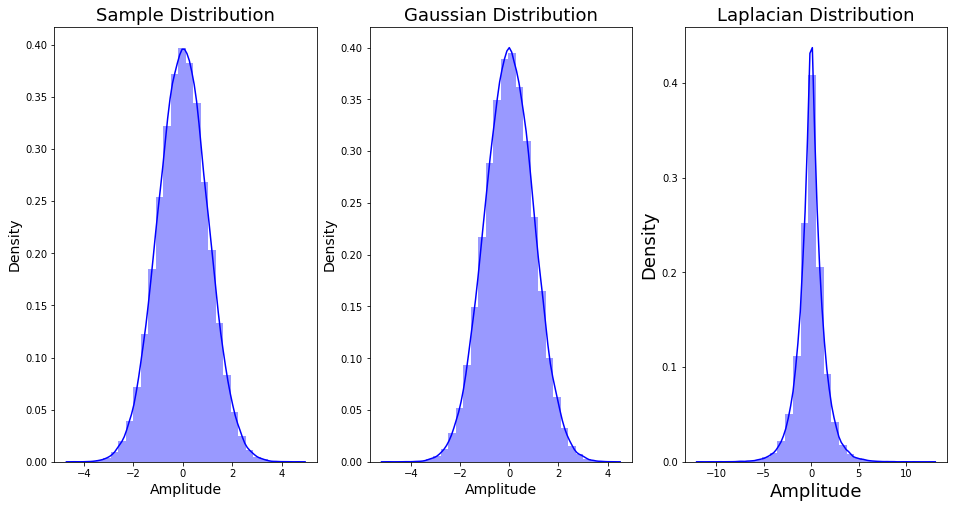

In [49]:
check_gaussianity(np.random.randn(len(dataBach)))

## Test Bach Sample

Normal Test p-value = 0.0000
Reject Null Hypothesis that sample comes from a normal distribution at alpha = 0.05

Sample Distribution Skew = -9.9593  Kurtosis = 41.7558
Gaussian Distribution Skew = 0.3064  Kurtosis = 0.9362
Laplacian Distribution Skew = -2.6341  Kurtosis = 97.3416



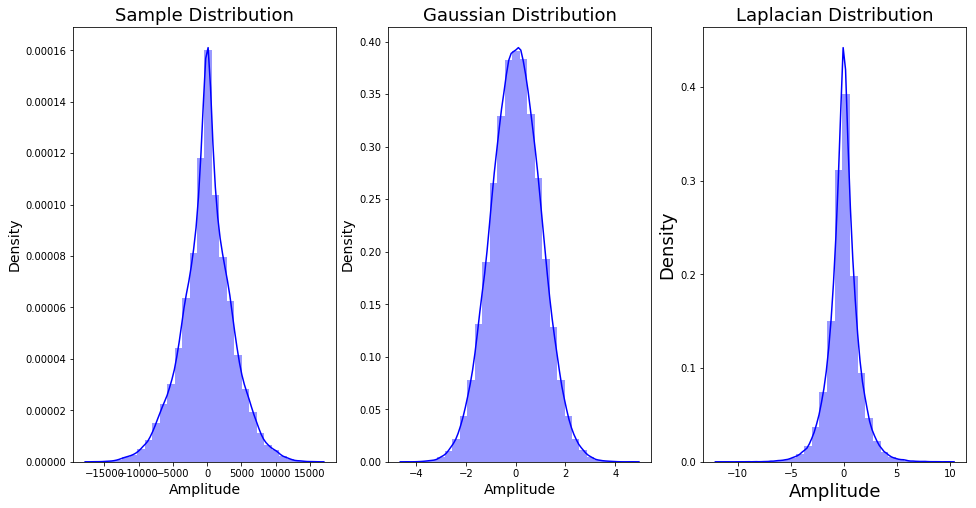

In [50]:
check_gaussianity(bach_sample)

## Test Speech Sample

Normal Test p-value = 0.0000
Reject Null Hypothesis that sample comes from a normal distribution at alpha = 0.05

Sample Distribution Skew = 15.9990  Kurtosis = 84.8716
Gaussian Distribution Skew = -1.4043  Kurtosis = 1.1985
Laplacian Distribution Skew = -1.5343  Kurtosis = 97.4603



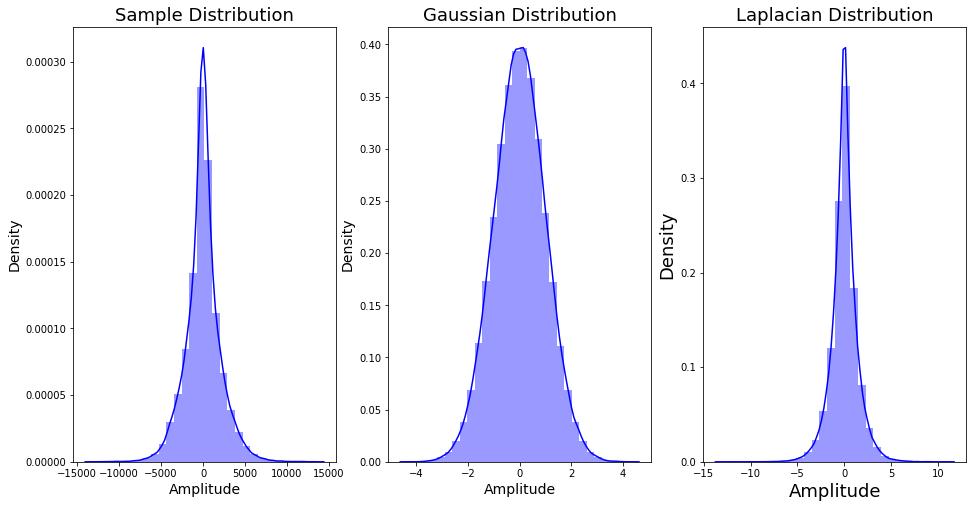

In [51]:
check_gaussianity(speech_sample)

## Mix Bach and Speech Samples

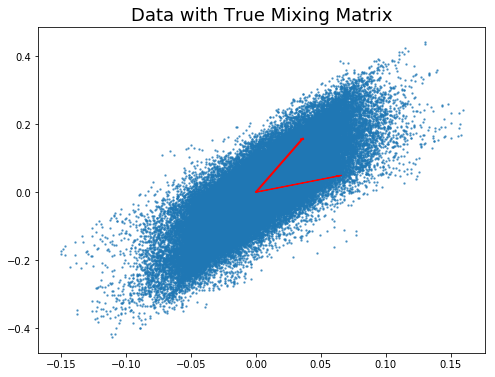

In [72]:
samples = audionorm([bach_sample, speech_sample])
X, true_A = simpleMixer(samples)

drawDataWithMixingMatrix(X, true_A)

## Visualize Samples and Mixed Signal

In [94]:
def plot_samples_mixed(samples, signal):
    # Independent Samples
    plt.figure(figsize=(8, 6))
    plt.plot(samples[0, :], label = 'Sample 1')
    plt.plot(samples[1, :], label = 'Sample 2')
    plt.legend()
    plt.title('Samples', size = 18)
    plt.show(); 
    
    # Mixed signal
    plt.figure(figsize=(8, 6))
    plt.plot(signal[0, :], alpha = 1.0, label = 'Mixed 1')
    plt.plot(signal[1, :], alpha = 0.6, label = 'Mixed 2')
    plt.legend()
    plt.title('Mixed Signal', size = 18)
    plt.show();

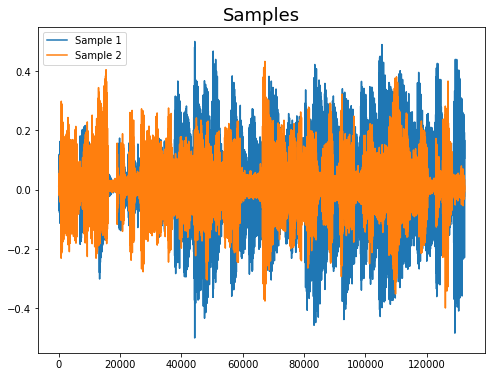

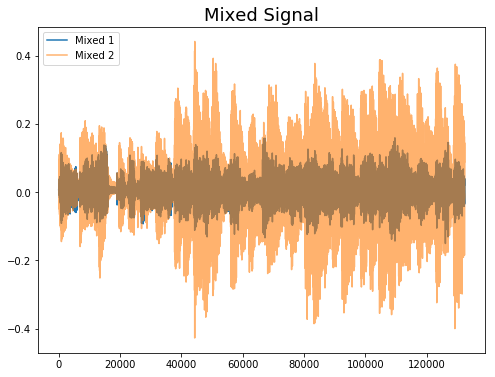

In [95]:
plot_samples_mixed(samples, X)

# Verify ICA Implementation

In [96]:
def generate_laplacian_data(n_samples, mixing):
    # Laplacian distributions
    s1 = np.random.laplace(size = n_samples)
    s2 = np.random.laplace(size = n_samples)
    
    # Combine into one array
    S = np.array([s1, s2])
    
    # Mix samples
    generated_data = mixing.dot(S)
    
    return generated_data, S

In [135]:
verify_mixing = np.array([[-1, 1],
                          [2, 2]])

verify_signal, verify_samples = generate_laplacian_data(n_samples = 10000, mixing = verify_mixing)

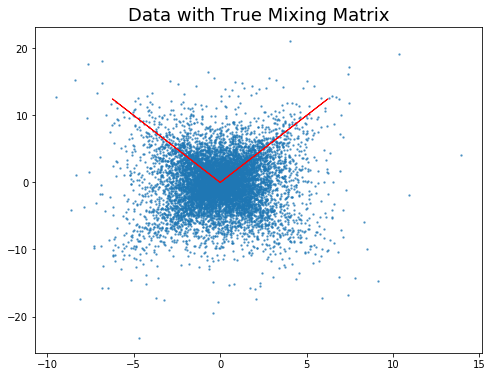

In [136]:
drawDataWithMixingMatrix(verify_signal, verify_mixing)

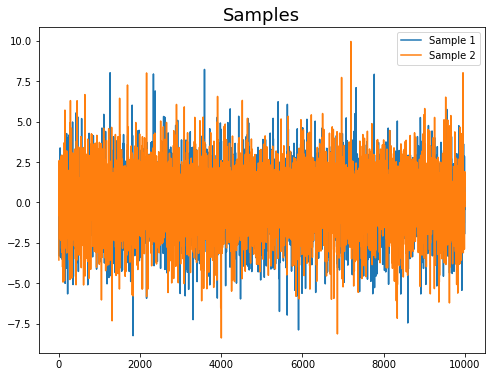

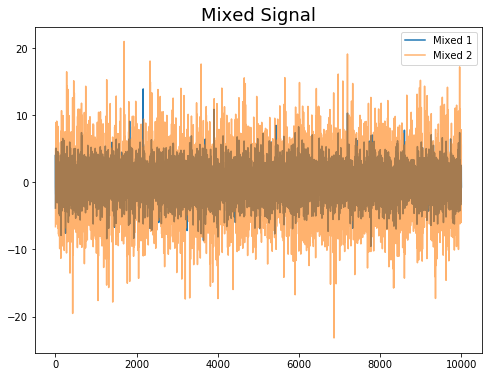

In [137]:
plot_samples_mixed(verify_samples, verify_signal)

In [138]:
mixing, sources, mean = perform_fastica(verify_signal.T, n_components = 2)

In [139]:
sources.shape

(10000, 2)

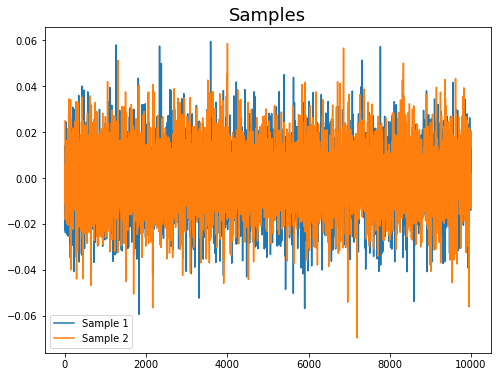

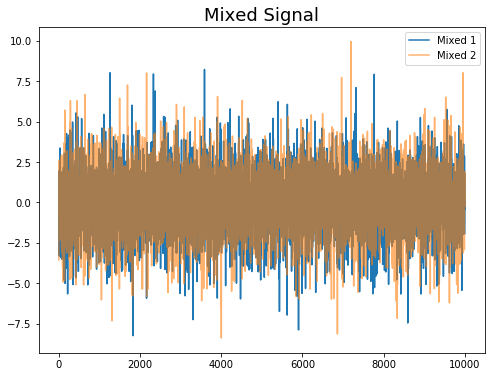

In [140]:
plot_samples_mixed(sources.T, verify_samples)

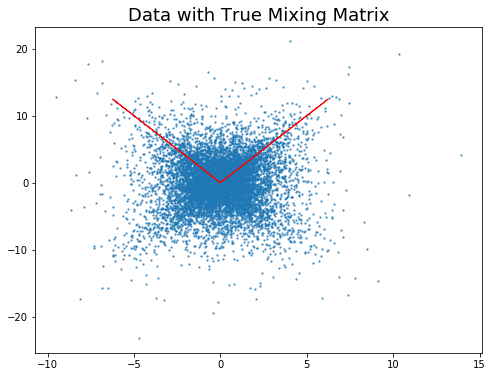

In [141]:
drawDataWithMixingMatrix(verify_signal, verify_mixing)

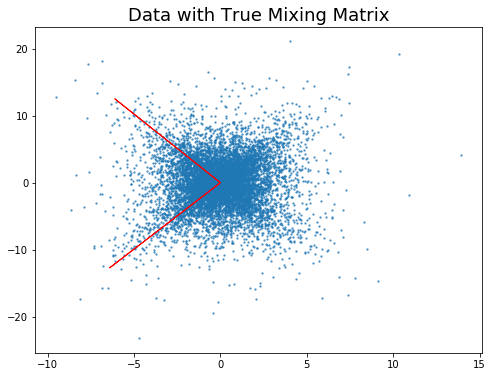

In [148]:
drawDataWithMixingMatrix(verify_signal, mixing)

In [143]:
from sklearn.decomposition import FastICA

ica = FastICA(n_components=2)
S = ica.fit_transform(verify_signal.T)

In [144]:
S.shape

(10000, 2)

In [145]:
ica.mixing_

array([[-143.50591503,  136.90324248],
       [-284.82042402, -280.29392736]])

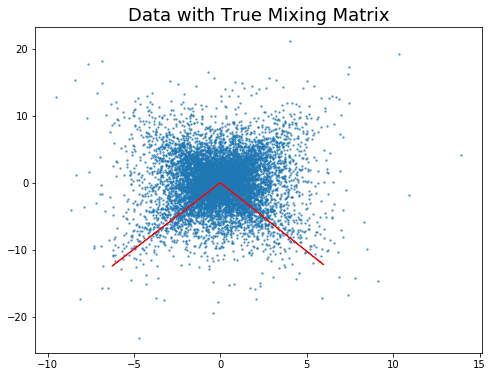

In [147]:
drawDataWithMixingMatrix(verify_signal, ica.mixing_)

In [127]:
mixing.T

array([[-9.19723741e-15, -9.19723741e-15],
       [-5.06574074e-15, -5.06574074e-15]])

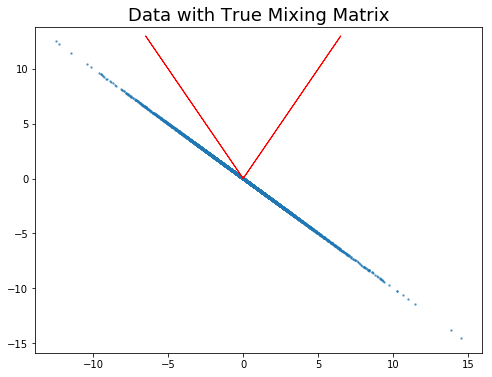

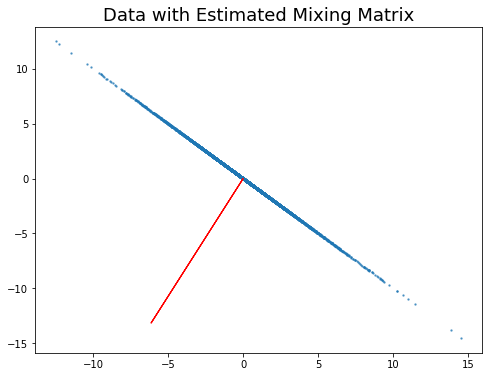

In [109]:
compareMixingMatrix(verify_signal, verify_mixing, mixing.T)

In [110]:
mixing

array([[-6.90730114e-15, -1.48374704e-14],
       [-6.90730114e-15, -1.48374704e-14]])

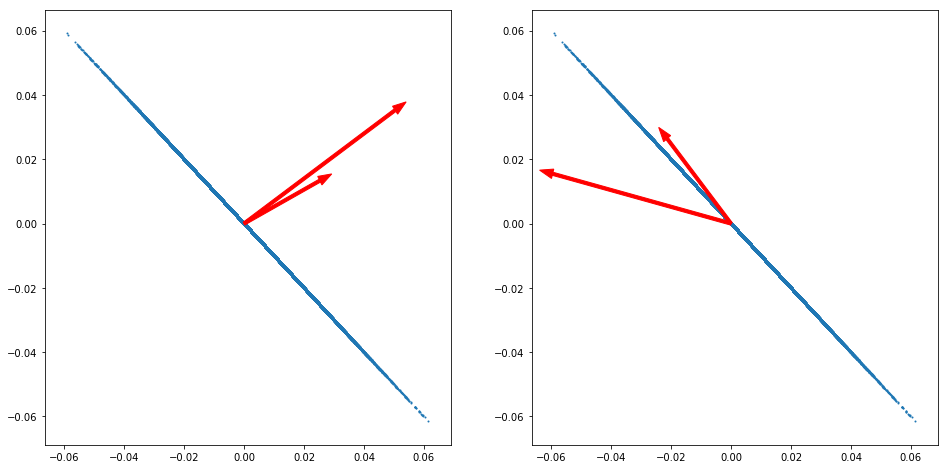

In [32]:
compareMixingMatrix(X, gtruthA, S)

In [27]:
A

array([[ 0.18975004,  0.02179344],
       [-0.00351193, -0.00040336],
       [-0.00337811, -0.00038799],
       ...,
       [-0.02290494, -0.00263071],
       [-0.01848791, -0.0021234 ],
       [-0.01468924, -0.00168711]])

In [28]:
gtruthA

array([[0.39882637, 0.79506323],
       [0.21036049, 0.55611523]])

In [29]:
A.shape

(132362, 2)

In [30]:
S.shape

(2, 2)

In [31]:
S

array([[-0.53827286, -1.50335693],
       [ 0.6668396 ,  0.39086914]])